In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
from ar_funcs import AR_rank
from wrf_preprocess import preprocess_2Dvar
import nclcmaps as nclc
from plotter import draw_basemap

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
server = 'comet'
if server == 'skyriver':
    path_to_data = '/home/dnash/SEAK_clim_data/'
    path_to_wrf = path_to_data + 'downloads/wrf-AK/'
elif server == 'comet':
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
    path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
    path_to_wrf = path_to_data + 'downloads/SEAK-WRF/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
### TODO: make a yaml dict
ext1 = [-141., -130., 54., 61.] # extent of SEAK 
ext2 = [-150., -129., 53, 62]

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

In [4]:
def preprocess_PCPT_test(filenames):
    """preprocess_prec from SEAK WRF data
    
    Returns a ds object (xarray) including the ACCUMULATED TOTAL GRID SCALE PRECIPITATION (mm)
    Renames vars so that they are cf-compliant
    Used http://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/WRF/wrf_ex.html as example
    
    Parameters
    ----------
    filenames : list
        list of wrf filenames to process
  
    Returns
    -------
    ds : ds object
        includes variables PCPT "ACCUMULATED TOTAL GRID SCALE PRECIPITATION" (mm)
    
    """

    # open each file
    f = xr.open_mfdataset(filenames, combine='by_coords', parallel=True, engine='netcdf4')

    # start with fixing times
    f = f.assign(Time=f.time.values)
    f = f.drop(['time']) # drop time variable
    f = f.rename({'Time':'time'})

    # now let's fix coordinates
    f = f.assign_coords(lat=f['lat'], lon=f['lon']) # reassign lat and lon as coords
    f = f.rename({'south_north':'y', 'west_east':'x'}) # rename coords to be cf-compliant

    # drop all other vars except precip
    varlst = list(f.keys())
    varlst.remove('PCPT')
    f = f.drop(varlst)
    f = f.drop(['interp_levels'])


    return f

In [5]:
def preprocess_2Dvar_new(filenames, varname):
    """preprocess 2D var from SEAK WRF data
    
    Returns a ds object (xarray) including the indicated variable
    ex: varname = 'PCPT' - Preprocesses precipitation "ACCUMULATED TOTAL GRID SCALE PRECIPITATION" (mm)
    ex: varname = 'T2' - Preprocesses 2 m temperature "TEMP at 2 M" (K)
    
    Parameters
    ----------
    filenames : list
        list of wrf filenames to process
    varname : str
        str of 2D varname to process
  
    Returns
    -------
    ds : ds object
        includes 2D variable requested to preprocess
    
    """
    # arrays to append data
    var_final = []
    da_time = []

    for i, wrfin in enumerate(filenames):
        
        f = xr.open_dataset(wrfin)

        # get lats and lons
        wrflats = f['lat'].values
        wrflons = f['lon'].values
         # extract the data we need
        data  = f[varname].values

        # get time steps from this file
        da_time.append(f.time.values)

        # put values into preassigned arrays
        var_final.append(data)
        
        # get units and attributes from original
        attributes = f.attrs
        var_attrs = f[varname].attrs

        f.close()

    # merge array of dates
    dates = np.concatenate(da_time, axis=0)
    
    # stack prec arrays
    data_array = np.concatenate(var_final, axis=0)

    # convert lats/lons to 4-byte floats (this alleviates striping issue)
    wrflats = np.float32(wrflats)
    wrflons = np.float32(wrflons)

    # put into a dataset
    var_dict = {varname: (['time', 'y', 'x'], data_array)}
    ds = xr.Dataset(var_dict,
                    coords={'time': (['time'], dates),
                            'lat': (['y', 'x'], wrflats),
                            'lon': (['y', 'x'], wrflons)})
    
    # set dataset and dataarray attributes
    ds[varname].attrs = var_attrs
    ds.attrs = attributes

    return ds

### Import preprocessed WRF data

In [ ]:
%%time
# get list of filenames that contain data from that year from current year folder
year = '1980'
output_varname = 'PCPT'
filenames = []
for name in glob.glob(path_to_wrf + '{0}/WRFDS_{0}-*'.format(year)):
    filenames.append(name)
# sort filenames so they are in chronological order
filenames = sorted(filenames)
# wrf = preprocess_PCPT_test(filenames)
# wrf = preprocess_2Dvar(filenames, output_varname)
# wrf = preprocess_PCPT(filenames)
wrf = preprocess_2Dvar_new(filenames, output_varname)


wrf

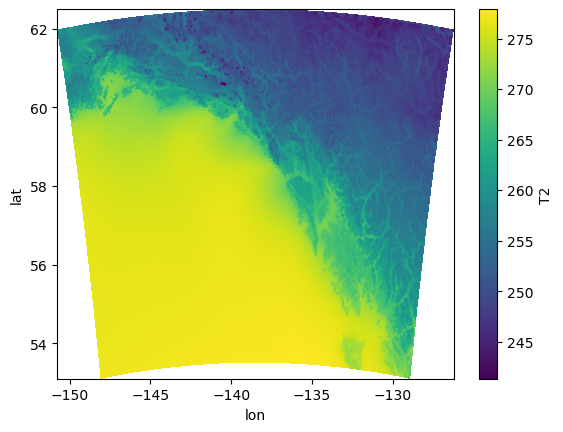

In [18]:
storm_total_prec = wrf.sum('time')
fig = plt.figure()

storm_total_prec.PCPT.plot(x='lon', y='lat')

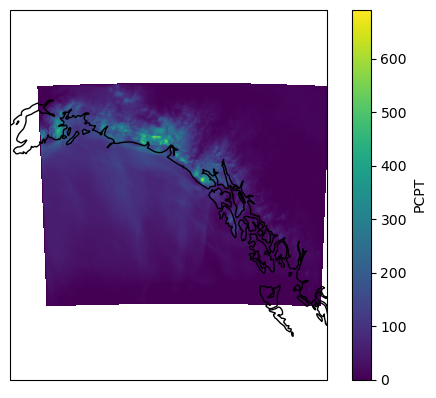

In [29]:
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
datacrs = ccrs.PlateCarree()

p = storm_total_prec.PCPT.plot(x='lon', y='lat',
    transform=datacrs,  # the data's projection
    subplot_kws={"projection": mapcrs},
)  # the plot's projection

# We have to set the map's options on all axes
p.axes.coastlines()
p.axes.set_extent([-150, -129, 50, 65])

/home/dnash/miniconda3/envs/SEAK-clim/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


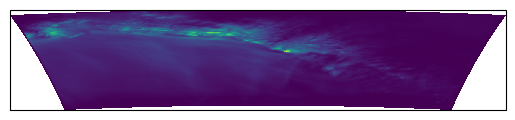

In [16]:
# set up a map
ax = plt.axes(projection=ccrs.PlateCarree())

gridlons = storm_total_prec.lon.values
gridlats = storm_total_prec.lat.values

# define the coordinate system that the grid lons and grid lats are on
rotated_pole = ccrs.RotatedPole(pole_longitude=138.5, pole_latitude=58.)
mapcrs = ccrs.LambertConformal(central_longitude=-138.5, central_latitude=58.0)
plt.pcolormesh(gridlons, gridlats, storm_total_prec.PCPT.values, transform=mapcrs)

ax.coastlines()

plt.show()

### Plot Storm Total Precipitation

In [19]:
# Set up projection
mapcrs = ccrs.Mercator()
# Define the data projection
globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
# mapcrs = ccrs.LambertConformal(globe=globe, central_longitude=-138.5, central_latitude=58.0, standard_parallels=(30., 60.))
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = wrf.lat.values
lons = wrf.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+1,1)
dy = np.arange(lats.min().round(),lats.max().round()+1,1)

ext_new = [lons.min(), lons.max(), lats.min(), lats.max()]

Max storm total: <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Data variables:
    PCPT     float32 691.5>


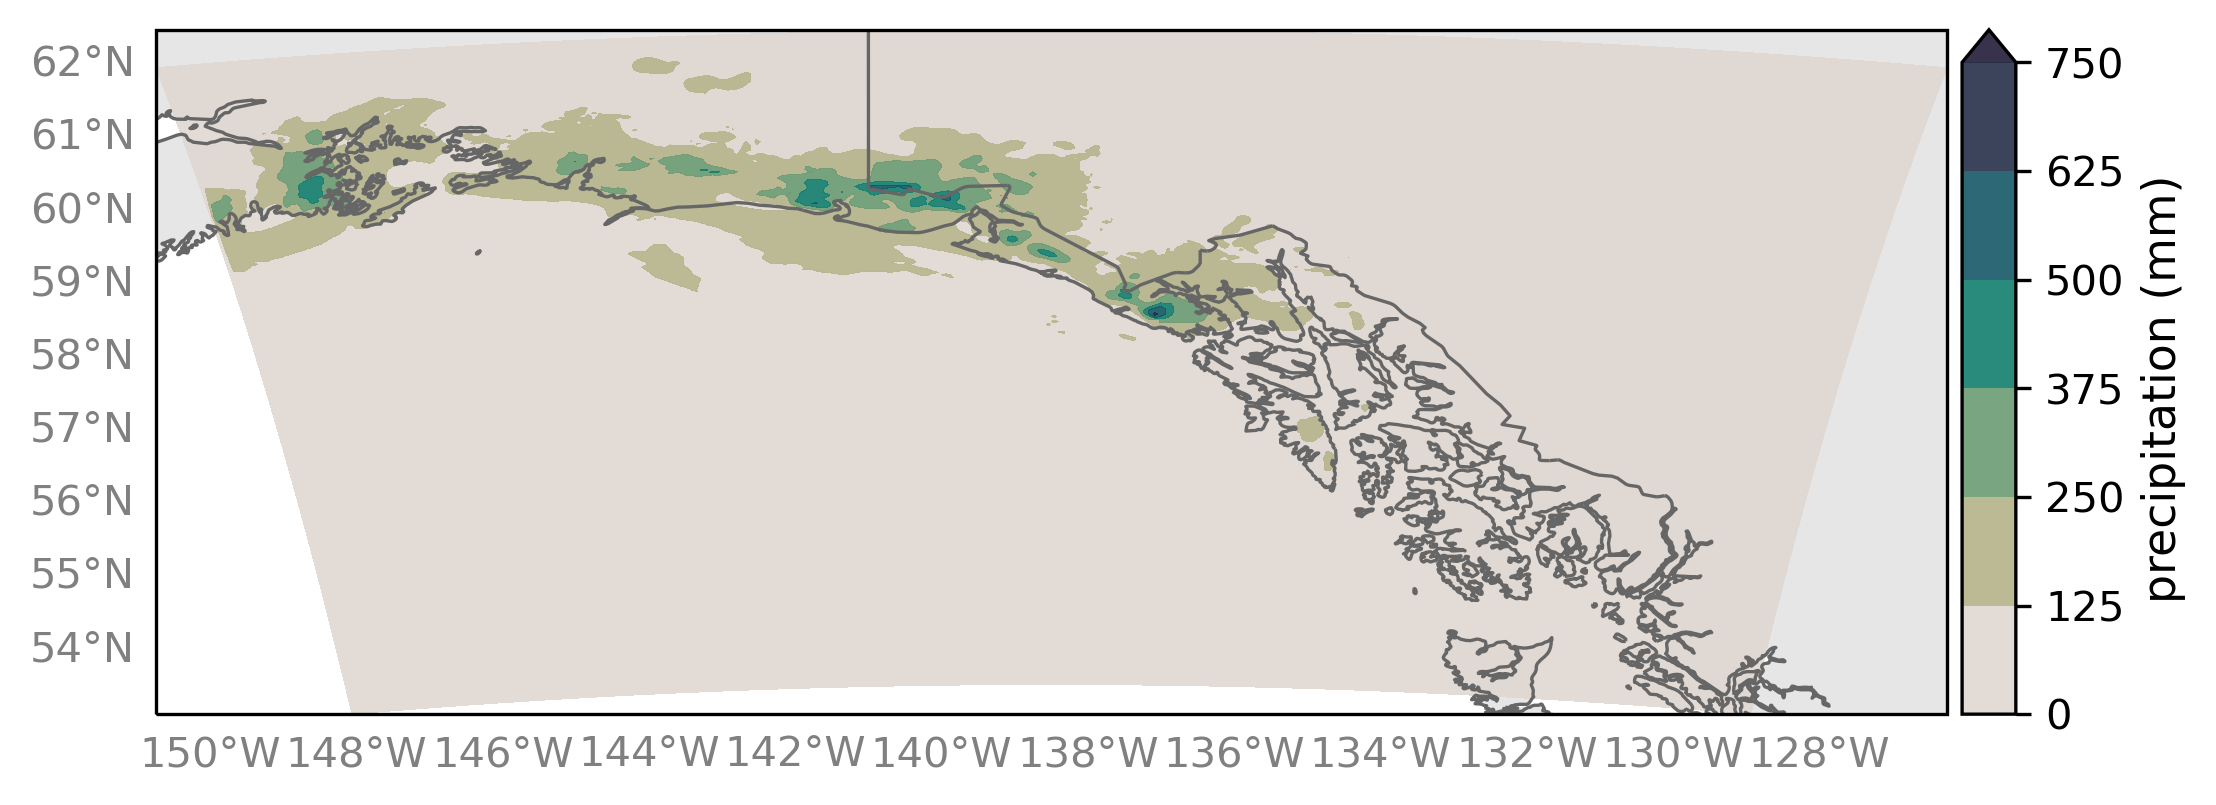

In [21]:
storm_total_prec = wrf.sum('time')
print('Max storm total:', storm_total_prec.max().values)

# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'SEAK-WRF-test'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext_new, xticks=dx, yticks=dy,left_lats=True, right_lats=False)

    # Contour Filled
    prec = storm_total_prec.PCPT.values
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=np.arange(0, 800, 125), cmap=cmo.rain, alpha=0.9, extend='max')


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('precipitation (mm)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()